In [48]:
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import netCDF4 as nc
import numpy as np
import random
from scipy.integrate import ode
from scipy.interpolate import LinearNDInterpolator

%matplotlib inline

* Staggered grids : Done
* Multiple points : Done
* tmask : Done (or at least fake one done)
* off depth and onto grid (done)
* e1t etc (sketched)
* the surface (badly done)

In [249]:
def interpolator(t_mask, e3w, e2v, e1u, w_coords, v_coords, u_coords, w, v, u, point) :
    dims = len(point)
    rhs = np.zeros((3))
    if t_mask[int(point[1]), int(point[2]), int(point[3])] != 0:
        for vel, scale, coords, data in zip([0, 1, 2], [e3w, e2v, e1u,], [w_coords, v_coords, u_coords], [w, v, u]):
            indices = []
            sub_coords = []
            for j in range(dims) :
                idx = np.digitize([point[j]], coords[j])[0]   # finds the index of region
                if (idx == len(coords[j])):
                    print (j, 'out of bounds', point[j], vel, coords[j])
                if (idx == 0):
                    print (j, 'hit surface', point[j], vel, coords[j])
                indices += [[idx - 1, idx]]
                sub_coords += [coords[j][indices[-1]]]
            indices = np.array([j for j in product(*indices)])
            sub_coords = np.array([j for j in product(*sub_coords)])
            sub_data = data[list(np.swapaxes(indices, 0, 1))]
            li = LinearNDInterpolator(sub_coords, sub_data)
            rhs[vel] = li([point])[0]/scale
    return rhs
# from Jaime on Stackoverflow https://stackoverflow.com/users/110026/jaime

In [230]:
def derivatives(t, poss, t_mask, e3w, e2v, e1u, w_coords, v_coords, u_coords, w, v, u):
    rhs = np.zeros_like(poss)
    for ip in range(int(poss.shape[0]/3)):
        point = np.array([t, poss[0+ip*3], poss[1+ip*3], poss[2+ip*3]])
        rhs[0+ip*3:3+ip*3] = interpolator(t_mask, e3w, e2v, e1u, w_coords, v_coords, u_coords, w, v, u, point)
    return np.array(rhs) # array or scalar, not a tuple

In [302]:
# Choose points
yi = np.zeros((27, 3))

tc = random.uniform(t0, t0+deltat)
zc = random.uniform(0., 1.)
yc = random.uniform(t_coords[2, 0], t_coords[2, -1])
xc = random.uniform(t_coords[3, 0], t_coords[3, -1])

print (tc, zc, yc, xc)

for k in range(3):
    for j in range(3):
        for i in range(3):
            yi[k, j, i] = [zc + k, yc + j, xc + i]

(4, 21)
[  1.49709780e+09   1.49710140e+09   1.49710500e+09   1.49710500e+09
   1.49710500e+09   1.49710500e+09   1.49710500e+09   1.49710500e+09
   1.49710500e+09   1.49710500e+09   1.49710500e+09   1.49710500e+09
   1.49710500e+09   1.49710500e+09   1.49710500e+09   1.49710500e+09
   1.49710500e+09   1.49710500e+09   1.49710500e+09   1.49710500e+09
   1.49710500e+09]
1497098167.09 0.23573497090288886 258.837184205 301.398559072


In [273]:
# Set up run: test points are not on the walls
print (w.shape, w_coords.shape)
print (v.shape, v_coords.shape)
print (u.shape, u_coords.shape)
print (t_mask.shape, t_coords.shape)
print (yi)
testpoint = np.zeros((4))
print (testpoint.shape)
testpoint[1:] = yi[0]
testpoint[0] = t0
print (testpoint)
velocity = interpolator(t_mask, e3w, e2v, e1u, w_coords, v_coords, u_coords, w, v, u, testpoint)
print (velocity)
if np.all(velocity == [0, 0, 0]):
    t_mask[int(testpoint[1]), int(testpoint[2]), int(testpoint[3])] = 0
    print (int(testpoint[1]), int(testpoint[2]), int(testpoint[3]), 'zerod')
testpoint[1:] = yi[1]
print (testpoint)
velocity = interpolator(t_mask, e3w, e2v, e1u, w_coords, v_coords, u_coords, w, v, u, testpoint)
print (velocity)
if np.all(velocity == [0, 0, 0]):
    t_mask[int(testpoint[1]), int(testpoint[2]), int(testpoint[3])] = 0
    print (int(testpoint[1]), int(testpoint[2]), int(testpoint[3]), 'zerod')

(3, 6, 21, 21) (4, 21)
(3, 6, 21, 21) (4, 21)
(3, 6, 21, 21) (4, 21)
(40, 898, 398) (4, 21)
[[   2.4274271   260.33152192  314.47658005]
 [   0.73223081  257.09782458  305.4965572 ]]
(4,)
[  1.49709780e+09   2.42742710e+00   2.60331522e+02   3.14476580e+02]
[ 0.  0.  0.]
2 260 314 zerod
[  1.49709780e+09   7.32230810e-01   2.57097825e+02   3.05496557e+02]
[  1.19897695e-05  -3.56751776e-05  -1.03925894e-04]


[   2.4274271   260.33152192  314.47658005    0.73223073  256.98304052
  304.66376389]
1497106800.0 4
1497110400.0 5
1497114000.0 6
1497117600.0 7
1497121200.0 8
1497124800.0 9
1497128400.0 10
1497132000.0 11


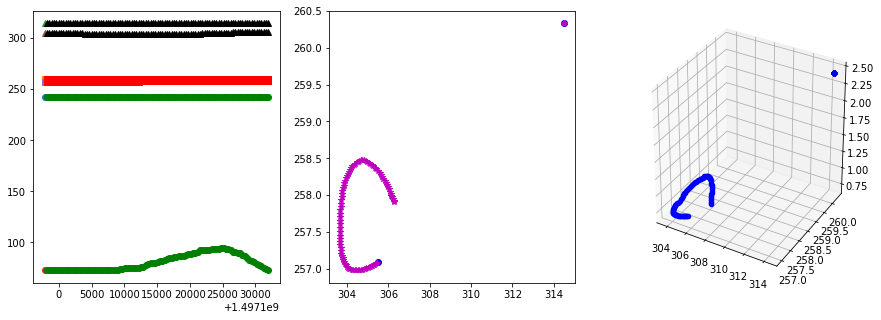

In [298]:
# Main Cell
fig = plt.figure(figsize=(15, 5))
ax[0] = fig.add_subplot(1, 3, 1)
ax[1] = fig.add_subplot(1, 3, 2)
ax[2] = fig.add_subplot(1, 3, 3, projection='3d')
myintegrator = ode(derivatives).set_integrator('dopri5', atol=0.01)
t0 = tcorrs[0]
npoints = 2
scale = 100.
y0 = np.copy(yi)

yp = np.ndarray.flatten(y0)

for ip in range(npoints):
    ax[0].plot(t0, y0[ip, 0]*scale, 'o')
    ax[0].plot(t0, y0[ip, 1], 's')
    ax[0].plot(t0, y0[ip, 2], '^')
    ax[1].plot(y0[ip, 2], y0[ip, 1], 'bo')
    ax[2].scatter(y0[ip, 2], y0[ip, 1], y0[ip, 0], c='y')
    

myintegrator.set_initial_value(yp, t0).set_f_params(t_mask, e3w, e2v, e1u, w_coords, v_coords, u_coords, w, v, u)
dt = deltat/10.
t1 = t0 + 1.5*deltat

testpointn = np.zeros((4))

while myintegrator.successful() and myintegrator.t < t1:
    myintegrator.integrate(myintegrator.t + dt)
    y0 = np.reshape(myintegrator.y, (npoints, 3))
    for ip in range(npoints):
        ax[0].plot(myintegrator.t, y0[ip, 0]*scale, 'go')
        ax[0].plot(myintegrator.t, y0[ip, 1], 'rs')
        ax[0].plot(myintegrator.t, y0[ip, 2], 'k^')
        ax[1].plot(y0[ip, 2], y0[ip, 1], 'm*')
        ax[2].scatter(y0[ip, 2], y0[ip, 1], y0[ip, 0], c='b')
 
print(myintegrator.y)

for count in range(8):
        
    # update arrays
    tcorrs, u_coords, v_coords, w_coords, u, v, w, nextindex = (
        update_arrays(tcorrs, u_coords, v_coords, w_coords, u, v, w, deltat, nextindex))
    t1 += deltat
    print (t1, nextindex)

    while myintegrator.successful() and myintegrator.t < t1:
        myintegrator.integrate(myintegrator.t + dt)
        y0 = np.reshape(myintegrator.y, (npoints, 3))
        for ip in range(npoints):
            ax[0].plot(myintegrator.t, y0[ip, 0]*scale, 'go')
            ax[0].plot(myintegrator.t, y0[ip, 1], 'rs')
            ax[0].plot(myintegrator.t, y0[ip, 2], 'k^')
            ax[1].plot(y0[ip, 2], y0[ip, 1], 'm*')
            ax[2].scatter(y0[ip, 2], y0[ip, 1], y0[ip, 0], c='b')

In [261]:
print (yp)
testpointn = np.zeros((4))
testpointn[1:] = yp[0:3]
testpointn[0] = t0
print (testpointn)
velocity = interpolator(t_mask, e3w, e2v, e1u, w_coords, v_coords, u_coords, w, v, u, testpointn)
print (velocity)

[   2.09779632  255.13152487  301.04620357    2.14403199  269.64935333
  305.48853622]
[  1.49709780e+09   2.09779632e+00   2.55131525e+02   3.01046204e+02]
[ -4.97211030e-05  -5.43426471e-07  -5.16098596e-06]


In [216]:
def update_arrays(tcorrs, u_coords, v_coords, w_coords, u, v, w, deltat, nextindex):
    tcorrs  = tcorrs + deltat
    u_coords[0, 0:len(tcorrs)] = tcorrs
    u_coords[0, len(tcorrs):] = max(tcorrs)
    v_coords[0] = u_coords[0]
    w_coords[0] = u_coords[0]
    u[0:2] = u[1:3]
    u[2, 1:] = udataset['uVelocity'][nextindex]
    u[2, 0] = 2 * u[2, 2] - u[2, 1]
    v[0:2] = v[1:3]
    v[2, 1:] = vdataset['vVelocity'][nextindex]
    v[2, 0] = 2 * v[2, 2] - v[2, 1]
    w[0:2] = w[1:3]
    w[2] = wdataset['wVelocity'][nextindex]
    nextindex += 1
    return tcorrs, u_coords, v_coords, w_coords, u, v, w, nextindex

In [297]:
# Set up the Data
udataset = nc.Dataset('/Users/sallen/Downloads/ubcSSn3DuVelocity1hV16-10_9411_b69f_35e1.nc')
# print (udataset)
tcorrs = udataset['time'][:3]
deltat = tcorrs[1] - tcorrs[0]
xcorrs = udataset['gridX'][:]
ycorrs = udataset['gridY'][:]
depthsize = udataset['depth'][:].shape[0]
zcorrs = np.linspace(0, depthsize, depthsize+1)  # this makes it depth, not grid point

longaxis = max(len(xcorrs), len(ycorrs), len(zcorrs), len(tcorrs))
print (longaxis)
t_coords = np.zeros((4, longaxis))
t_coords[0, 0:len(tcorrs)] = tcorrs
t_coords[0, len(tcorrs):] = max(tcorrs)
t_coords[1, 0:len(zcorrs)] = zcorrs
t_coords[1, len(zcorrs):] = max(zcorrs)
t_coords[2, 0:len(ycorrs)] = ycorrs
t_coords[2, len(ycorrs):] = max(ycorrs)
t_coords[3, 0:len(xcorrs)] = xcorrs
t_coords[3, len(xcorrs):] = max(xcorrs)
print (t_coords.shape)
# other grids
u_coords = np.copy(t_coords)
u_coords[3] = t_coords[3] + 0.5
v_coords = np.copy(t_coords)
v_coords[2] = t_coords[2] + 0.5
w_coords = np.copy(t_coords)
w_coords[1] = t_coords[1] + 0.5

u = np.zeros((3, len(zcorrs), len(ycorrs), len(xcorrs)))
print (u.shape)
u[:, 1:] = udataset['uVelocity'][0:3]
u[:, 0] = 2 * u[:, 2] - u[:, 1]
print (u.shape)

v = np.zeros_like(u)
vdataset = nc.Dataset('/Users/sallen/Downloads/ubcSSn3DvVelocity1hV16-10_a2b6_f6ad_26bd.nc')
v[:, 1:] = vdataset['vVelocity'][0:3]
v[:, 0] = 2 * v[:, 2] - v[:, 1]
print (v.shape)

wdataset = nc.Dataset('/Users/sallen/Downloads/ubcSSn3DwVelocity1hV16-10_9d37_aa6f_428c.nc')
w = np.zeros_like(u)
w = wdataset['wVelocity'][0:3]
#wdepths = g_depw
wdepths = np.zeros((3, 6, 21, 21))
for j in range(3):
    for i in range(6):
        wdepths[j, i] = wdataset['depth'][i]
w = w_correction(w, 150., wdepths)
print(w.shape)

nextindex = 3

t_mask = np.ones((40, 898, 398))
print (t_mask.shape)
t_mask[5:] = 0
t_mask[:, 0:int(t_coords[2, 0]+1)] = 0
t_mask[:, int(t_coords[2, -1]):] = 0
t_mask[..., 0:int(t_coords[3, 0]+1)] = 0
t_mask[..., int(t_coords[3, -1]):] = 0

print (t_coords[1, 2], t_coords[2, 0], t_coords[3, 2])
print (u[0, 2, 5, 2], v[0, 2, 5, 2], w[0, 0, 5, 2])
print (t_mask[2, 250, 311])
print (t_mask[4, 258, 312])
print (zcorrs)

# set scales, for now
e1u = 440
e2v = 500
e3w = 1

21
(4, 21)
(3, 6, 21, 21)
(3, 6, 21, 21)
(3, 6, 21, 21)
(3, 6, 21, 21)
(40, 898, 398)
2.0 250.0 302.0
-0.00781892426312 0.0108764423057 -0.0
0.0
1.0
[ 0.  1.  2.  3.  4.  5.]


In [296]:
def w_correction (w, total_depth, depth):
    '''w in nc files, is real, but we want w relative to grid
    that means w  at the surface is zero'''
    stretching = w[:, 0]/total_depth
    for i in range(6):
        w[:, i] =- stretching*depth[:, i]
    return w

In [221]:
udataset['depth'][:]

array([ 0.5000003 ,  1.5000031 ,  2.50001144,  3.50003052,  4.50007057], dtype=float32)

In [224]:
zcorrs = np.linspace(0, depthsize, depthsize+1)

In [226]:
wdataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    acknowledgement: MEOPAR, ONC, Compute Canada
    cdm_data_type: Grid
    Conventions: CF-1.6, COARDS, ACDD-1.3
    coverage_content_type: modelResult
    creator_email: sallen@eos.ubc.ca
    creator_name: Salish Sea MEOPAR Project Contributors
    creator_url: https://salishsea-meopar-docs.readthedocs.io/
    description: ocean W grid variables
    drawLandMask: over
    geospatial_vertical_max: 5.0001
    geospatial_vertical_min: 0.0
    geospatial_vertical_positive: down
    geospatial_vertical_units: m
    history: 2017-06-11T20:37:30Z (local files)
2017-06-11T20:37:30Z https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DwVelocity1hV16-10.nc?dissipation[(2017-06-10T12:30:00Z):1:(2017-06-10T23:30:00Z)][(0.0):1:(5.5)][(250):1:(270)][(300):1:(320)],vert_eddy_diff[(2017-06-10T12:30:00Z):1:(2017-06-10T23:30:00Z)][(0.0):1:(5.5)][(250):1:(270)][(300):1:(320)],vert_eddy_visc[(2017-06-10T12:3